In [2]:
tf.constant(10)

<tf.Tensor: shape=(), dtype=int32, numpy=10>

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Add, Activation, GlobalAveragePooling2D

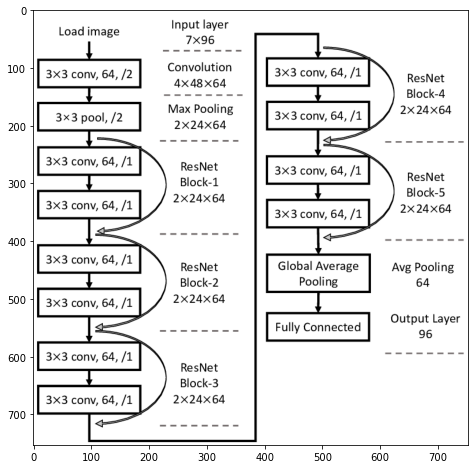

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open('resney.png')
plt.figure(figsize=(12, 8))
plt.imshow(im)

In [7]:
from keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [9]:
from keras.utils import np_utils

num_classes = 10 
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [10]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


$\frac{W-K+2P}{S} + 1$

In [11]:
weight_init = tf.keras.initializers.VarianceScaling()
weight_regularizer = tf.keras.regularizers.l2(l=0.0001)

is_channel_first = False

class resnet(tf.keras.models.Model):
    def __init__(self,input_shape=(28, 28, 1), label_dim=10):
        super().__init__()
        inputs = tf.keras.layers.Input(shape=input_shape)
        self.x = inputs
        self.res_n = 50
        self.label_dim = label_dim
        self.model()
        x = self.x
        self.model = tf.keras.Model(inputs, x)
        

    
    def get_residual_layer(self):
        n_to_residual = {
            10: [1, 1, 1, 1],
            12: [1, 1, 2, 1],
            14: [1, 2, 2, 1],
            16: [2, 2, 2, 1],
            18: [2, 2, 2, 2],
            20: [2, 2, 3, 2],
            22: [2, 3, 3, 2],
            24: [2, 3, 4, 2],
            32: [3, 4, 6, 2],
            50: [3, 4, 6, 3]
        }
        return n_to_residual[self.res_n]
    
    def model(self):
        if is_channel_first:
            self.x = tf.transpose(self.x, [0, 3, 1, 2])
            tf.keras.backend.set_image_data_format("channels_first")
        
        if self.res_n < 50:
            residual_block = self.resblock
        else:
            False
            residual_block = self.bottle_resblock
        residual_list = self.get_residual_layer()
        ch = 64
        self.x = Conv2D(int(ch), 7, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, padding="same")(self.x)
        self.x = MaxPool2D(pool_size=3, strides=2)(self.x)
        for i in range(residual_list[0]):
            residual_block(channels=int(ch), downsample=False,)
        # block 1
        residual_block(channels=int(ch) * 2, downsample=True)
        for i in range(1, residual_list[1]):
            residual_block(channels=int(ch) * 2, downsample=False,)
        # block 2
        residual_block(channels=int(ch) * 4, downsample=True)
        for i in range(1, residual_list[2]):
            residual_block(channels=int(ch) * 4, downsample=False,)
        # block 3
        residual_block(channels=int(ch) * 8, downsample=True)
        for i in range(1, residual_list[3]):
            residual_block(channels=int(ch) * 8, downsample=False,)
        # block 4
        self.x = BatchNormalization()(self.x)
        self.x = Activation("relu")(self.x)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dense(units=self.label_dim, activation="softmax", kernel_initializer=weight_init, kernel_regularizer=weight_regularizer)(self.x)
        
        
    def resblock(self, channels, use_bias=True, downsample=False):
        x_init = self.x
        self.x = BatchNormalization()(self.x)
        self.x = Activation("relu")(self.x)
        if downsample:
            # Interestingly, downsampling for the main path is done with (3,3) filters,
            # In fact, stride=2 reduce the size by half
            self.x = Conv2D(channels, 3, 2, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                            use_bias=use_bias, padding="same")(self.x)
            x_init = Conv2D(channels, 1, 2, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                            use_bias=use_bias, padding="same")(self.x)
            
        else:
            self.x = Conv2D(channels, 3, 1, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                            use_bias = use_bias, padding="same")(self.x)
        
        self.x = BatchNormalization()(self.x)
        self.x = Activation("relu")(self.x)
        self.x = Conv2D(channels, 3, 1,  kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                        use_bias=use_bias, padding="same")(self.x)
        self.x = Add()([self.x, x_init])
        
    def bottle_resblock(self, channels, use_bias=True, downsample=False):
        self.x = BatchNormalization()(self.x)
        shortcut = Activation('relu')(self.x)
        self.x = Conv2D(channels, 1, 1, 'same', kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                           use_bias=use_bias)(shortcut)
        self.x = BatchNormalization()(self.x)
        self.x = Activation('relu')(self.x)
        if downsample:
            self.x = Conv2D(channels, 3, 2, 'same', kernel_initializer=weight_init,
                             kernel_regularizer=weight_regularizer, use_bias=use_bias)(self.x)
            shortcut = Conv2D(channels * 4, 1, 2, 'same', kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                               use_bias=use_bias)(shortcut)
        else:
            self.x = Conv2D(channels, 3, 1, 'same', kernel_initializer=weight_init,
                             kernel_regularizer=weight_regularizer, use_bias=use_bias)(self.x)
            shortcut = Conv2D(channels * 4, 1, 1, 'same', kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                               use_bias=use_bias)(shortcut)
        self.x = BatchNormalization()(self.x)
        self.x = Activation('relu')(self.x)
        self.x = Conv2D(channels * 4, 1, 1, 'same', kernel_initializer=weight_init, kernel_regularizer=weight_regularizer,
                           use_bias=use_bias)(self.x)
        self.x = Add()([self.x, shortcut]) 

In [12]:
resnet = resnet()

In [13]:
resnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 13, 13, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

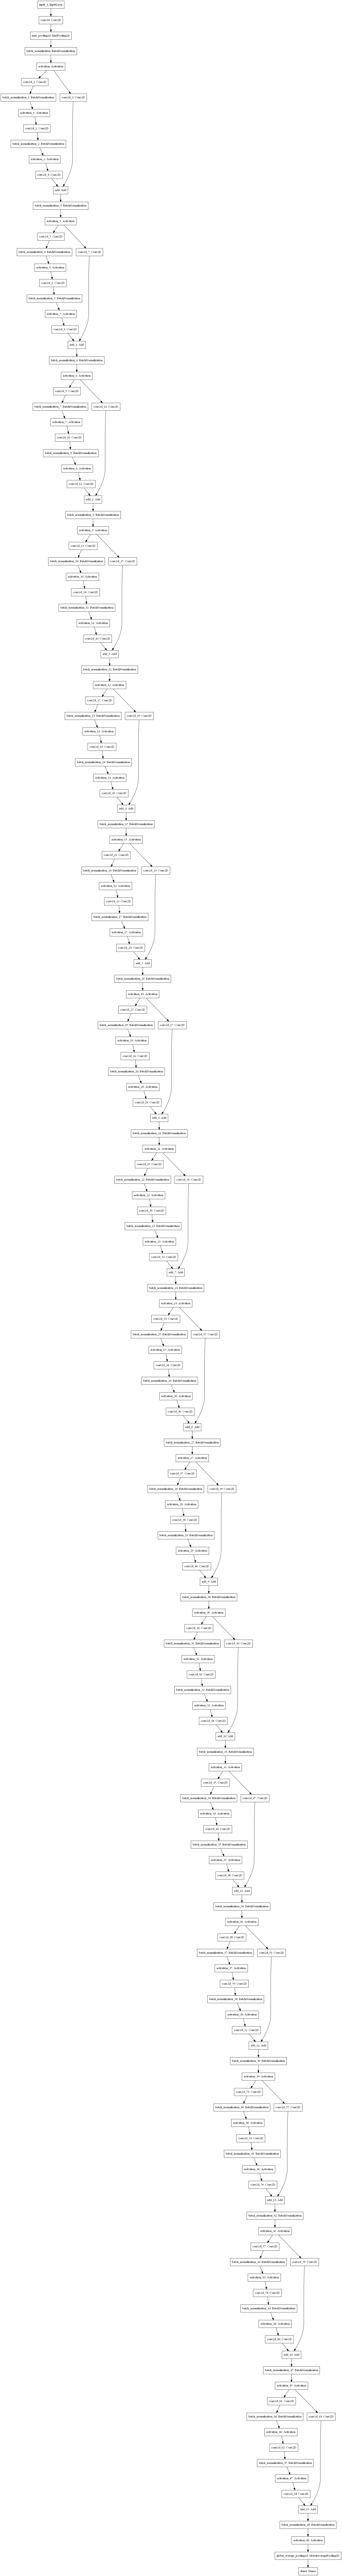

In [14]:
from keras.utils import plot_model
plot_model(resnet.model)

In [15]:
from keras.callbacks import ReduceLROnPlateau
 
epochs = 3                                                         
batch_size = 256                                                   
 
reduce_lr= ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1),
    patience=5, min_lr=0.5e-6)   

In [16]:
resnet.model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])    

In [17]:
y_test.shape

(10000, 10)

In [18]:
resnet.model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test),
          epochs=epochs, callbacks=[reduce_lr])   

Epoch 1/3
235/235 [==============================] - 63s 220ms/step - loss: 4.3673 - accuracy: 0.7836 - val_loss: 3.1624 - val_accuracy: 0.9322
Epoch 2/3
235/235 [==============================] - 49s 208ms/step - loss: 2.7355 - accuracy: 0.9802 - val_loss: 2.2609 - val_accuracy: 0.9405
Epoch 3/3
235/235 [==============================] - 49s 208ms/step - loss: 1.9537 - accuracy: 0.9866 - val_loss: 1.6695 - val_accuracy: 0.9712
